In [215]:
# import all packages and set plots to be embedded inline
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm 
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

Paper where algorithm was taken - can use their ideas for picking models and #iterations: https://www.nature.com/articles/s41524-021-00662-x

Code inspired by this repository: https://github.com/ShuaiGuo16/Surrogate_Optimization/tree/master

In [222]:
X, y = np.load("dataset/mass_batch.npy"), np.load("dataset/res_v.npy")

In [225]:
# Number of arrays to randomly sample
num_arrays_to_sample = 5  # You can adjust this as needed

#np.random.seed(41)
# Randomly choose one or more arrays from the nested array
random_arrays_indices = np.random.choice(X.shape[0], size=num_arrays_to_sample, replace=False)
random_arrays = X[random_arrays_indices]

# Print the result
print(f"Randomly chosen {num_arrays_to_sample} array(s):")
print(random_arrays)

initial_X = random_arrays

initial_y = []
for i in initial_X:
    indice = np.where(np.all(X == i, axis=1))[0][0]
    initial_y.append(y[indice])

initial_y = np.array(initial_y)

Randomly chosen 5 array(s):
[[0.09 0.72 0.2 ]
 [0.22 0.15 0.64]
 [0.53 0.35 0.12]
 [0.54 0.17 0.29]
 [0.25 0.34 0.41]]


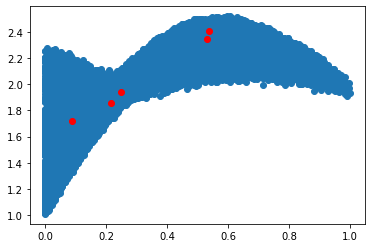

In [226]:
plt.scatter(X[:, 0], y)
plt.scatter(initial_X[:, 0], initial_y, color = 'red')

In [227]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current maxima
    current_objective = y_pred[np.argmax(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    #pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)

    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI, np.argmax(EI)

In [228]:
X_space, y_space = X.copy(), y.copy()

In [229]:
n_iterations = 100
FOM_values, EI_arr = [], []

for c in range(1, n_iterations + 1):
    print("Iteration # : {}".format(c))
    
    # Train initial Gaussian Process (GP) model
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
    kernel = 1.0 * gp.kernels.RBF(length_scale=1.0)
    model = gp.GaussianProcessRegressor(kernel=kernel, 
                                        optimizer='fmin_l_bfgs_b',
                                        n_restarts_optimizer=30, 
                                        alpha=1e-4, 
                                        normalize_y=True)
    
    model.fit(initial_X, initial_y)
    y_pred, pred_std = model.predict(X_space, return_std = True)
    pred_std = pred_std.flatten()

    new_sample, EI, idx = EI_learning(X_space, y_pred = y_pred, pred_std = pred_std) #gives new sample X-coords, EI, index of max(EI)
    print("New data point added : {}".format(new_sample))
    print("Corresponding FOM : {}".format(y_space[idx]))
    print("Target FOM : {}".format(np.max(y)))

    FOM_values.append(y_space[idx])
    EI_arr.append(EI)

    initial_X = np.vstack([initial_X, new_sample])
    initial_y = np.append(initial_y, y_space[idx])

    #removing previously defined new_sample from (X, y)
    X_space = np.array([nested_list for nested_list in X_space if not np.array_equal(nested_list, new_sample)])
    y_space = np.delete(y_space, idx)
    

Iteration # : 1
New data point added : [0. 0. 1.]
Corresponding FOM : 2.255905374610706
Target FOM : 2.5194805890136203
Iteration # : 2
New data point added : [0.07 0.71 0.22]
Corresponding FOM : 1.6678038273808689
Target FOM : 2.5194805890136203
Iteration # : 3
New data point added : [0.   0.66 0.34]
Corresponding FOM : 1.3118669785324484
Target FOM : 2.5194805890136203
Iteration # : 4
New data point added : [0.   0.58 0.42]
Corresponding FOM : 1.1598147928724338
Target FOM : 2.5194805890136203
Iteration # : 5
New data point added : [0.   0.52 0.48]
Corresponding FOM : 1.094986554922897
Target FOM : 2.5194805890136203
Iteration # : 6
New data point added : [0.  0.5 0.5]
Corresponding FOM : 1.0613148762436415
Target FOM : 2.5194805890136203
Iteration # : 7
New data point added : [0.   0.46 0.54]
Corresponding FOM : 1.097852164318204
Target FOM : 2.5194805890136203
Iteration # : 8
New data point added : [0.   0.49 0.51]
Corresponding FOM : 1.0384302115337631
Target FOM : 2.5194805890136

c:\Users\sarta\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


New data point added : [0.   0.46 0.54]
Corresponding FOM : 1.0270783186099153
Target FOM : 2.5194805890136203
Iteration # : 15
New data point added : [0.   0.45 0.55]
Corresponding FOM : 1.01731159690168
Target FOM : 2.5194805890136203
Iteration # : 16
New data point added : [0.01 0.5  0.49]
Corresponding FOM : 1.0990057063209213
Target FOM : 2.5194805890136203
Iteration # : 17
New data point added : [0.   0.49 0.5 ]
Corresponding FOM : 1.0375602989237511
Target FOM : 2.5194805890136203
Iteration # : 18


c:\Users\sarta\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


New data point added : [0.   0.45 0.54]
Corresponding FOM : 1.0532094764500335
Target FOM : 2.5194805890136203
Iteration # : 19
New data point added : [0.01 0.49 0.5 ]
Corresponding FOM : 1.1004300641475906
Target FOM : 2.5194805890136203
Iteration # : 20
New data point added : [0.  0.5 0.5]
Corresponding FOM : 1.0644205076526243
Target FOM : 2.5194805890136203
Iteration # : 21
New data point added : [0.   0.51 0.49]
Corresponding FOM : 1.1288776219702537
Target FOM : 2.5194805890136203
Iteration # : 22
New data point added : [0.02 0.5  0.48]
Corresponding FOM : 1.1908358588341246
Target FOM : 2.5194805890136203
Iteration # : 23
New data point added : [0.   0.45 0.55]
Corresponding FOM : 1.0593032114277658
Target FOM : 2.5194805890136203
Iteration # : 24
New data point added : [0.01 0.5  0.49]
Corresponding FOM : 1.0945474811247426
Target FOM : 2.5194805890136203
Iteration # : 25
New data point added : [0.   0.53 0.47]
Corresponding FOM : 1.108231471248514
Target FOM : 2.51948058901362

c:\Users\sarta\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


New data point added : [0.   0.44 0.55]
Corresponding FOM : 1.0526947549215089
Target FOM : 2.5194805890136203
Iteration # : 29
New data point added : [0.  0.5 0.5]
Corresponding FOM : 1.1012247031844387
Target FOM : 2.5194805890136203
Iteration # : 30
New data point added : [0.   0.54 0.46]
Corresponding FOM : 1.1028623933551478
Target FOM : 2.5194805890136203
Iteration # : 31
New data point added : [0.01 0.43 0.56]
Corresponding FOM : 1.0635773235314328
Target FOM : 2.5194805890136203
Iteration # : 32
New data point added : [0.01 0.43 0.56]
Corresponding FOM : 1.0618443396312964
Target FOM : 2.5194805890136203
Iteration # : 33
New data point added : [0.   0.54 0.46]
Corresponding FOM : 1.1127657761834922
Target FOM : 2.5194805890136203
Iteration # : 34
New data point added : [0.   0.56 0.44]
Corresponding FOM : 1.1293976922322315
Target FOM : 2.5194805890136203
Iteration # : 35
New data point added : [0.   0.55 0.45]
Corresponding FOM : 1.135676907846578
Target FOM : 2.51948058901362

c:\Users\sarta\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


New data point added : [0.01 0.43 0.56]
Corresponding FOM : 1.0912620991379445
Target FOM : 2.5194805890136203
Iteration # : 50
New data point added : [0.03 0.41 0.56]
Corresponding FOM : 1.1493920677559082
Target FOM : 2.5194805890136203
Iteration # : 51
New data point added : [0.  0.4 0.6]
Corresponding FOM : 1.1113860877377664
Target FOM : 2.5194805890136203
Iteration # : 52
New data point added : [0.02 0.4  0.58]
Corresponding FOM : 1.1619433120992346
Target FOM : 2.5194805890136203
Iteration # : 53
New data point added : [0.   0.39 0.61]
Corresponding FOM : 1.0927530437712965
Target FOM : 2.5194805890136203
Iteration # : 54
New data point added : [0.01 0.4  0.59]
Corresponding FOM : 1.1138978319862973
Target FOM : 2.5194805890136203
Iteration # : 55
New data point added : [0.02 0.39 0.59]
Corresponding FOM : 1.2041476196054406
Target FOM : 2.5194805890136203
Iteration # : 56
New data point added : [0.  0.4 0.6]
Corresponding FOM : 1.0506642076354649
Target FOM : 2.5194805890136203

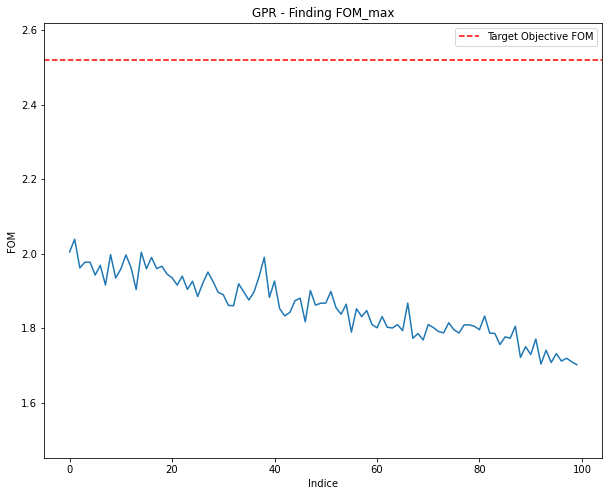

In [214]:
plt.figure(figsize=(10, 8))
plt.plot(FOM_values)
plt.axhline(y=np.max(y), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.ylim([np.min(FOM_values) - 0.25, np.max(y) + 0.1])

plt.title('GPR - Finding FOM_max')
plt.legend()
plt.show()

In [123]:
y_space.shape

(31596,)

In [124]:
X_space.shape

(31596, 3)